In [2]:
# We would like to compare the analytical solution with our MOOSE model, to make sure that the 
# geomechanical coupling and assumed BC acctually work. Also this will guide us to find the best 
# mesh set up.

# We generate MOOSE input files to simulate numerically Wang's solution. To do so, we start with a "base file"
# named wang_no_leakage_ts.i and we will edits its material properties (hydraulic conductivity) and sink flux to fit 
# Wang's solution.

# Note that for this simulation we wont change the steady solution since only permeability is changing.

# path to the base file (this may change depending on your set up)
# path to base file
base_path = '/home/jose/MEGA/PhD/Paper_2/RZ/model_validation/simulations/'
# path where input files will be storaged
sim_path = '/home/jose/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_earth/'
# path in work station (I run my simulations remotely)
sim_path_ws = '/home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_earth/'

# Generate permeability values
import numpy as np
# Generate permeability values
P_AQ = np.logspace(-9,-2, 15) * 1E-7
# Generate flux fun values
flux_fn = np.logspace(1,-4,15)
# Generate dt max
dt = np.linspace(500,50,15)
dt[-2] = 50 # Better convergence
dt[-3] = 50 # Better convergence

# We want to study two typical Earth tide period, so for each one we generate separate files
PERIOD = np.arange(1,3) * 24 * 3600 / 2 # s

for i, p in enumerate(PERIOD):
    for k, j in enumerate(range(len(P_AQ))):
        
        # Read in the file
        with open(base_path + 'wang_no_leakage_earth_ts.i', 'r') as file:
            filedata = file.read()
    
        # Replace the target string
        filedata = filedata.replace('1.0E-12 0 0 0 1.0E-150 0 0 0 1E-150', str(P_AQ[k]) + ' 0 0 0 1E-150 0 0 0 1E-150')
        filedata = filedata.replace('flux_function = 1E-4', 'flux_function = ' + str(flux_fn[k]))
        filedata = filedata.replace('dtmax = 250', 'dtmax = ' + str(dt[k]))
        
        if i == 0:
            filedata = filedata.replace('2*pi', '4*pi')
            
        # Write the file out again
        with open(sim_path + str(i) + str('_') + str(k) + '.i', 'w') as file:
            file.write(filedata)

# strings to run simulations in MOOSE (so you just need to copy and paste in a shell our you can make a python
# script that does this for you. In any case, I include this here)
act_moose = "conda activate moose;"
app = "mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i " + sim_path_ws

# Note that 2cp is represented as "0" in the file name and 1cp is represented as "1" in the file name.
two_cp = []
one_cp = []
for i, p in enumerate(PERIOD):
    for k in range(len(P_AQ)):
        comand = str(i) + str('_') + str(k) + ".i;"
        if i == 0:
            two_cp.append(act_moose + app + comand)
        else:
            one_cp.append(act_moose + app + comand)


In [3]:
two_cp

['conda activate moose;mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_earth/0_0.i;',
 'conda activate moose;mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_earth/0_1.i;',
 'conda activate moose;mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_earth/0_2.i;',
 'conda activate moose;mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_earth/0_3.i;',
 'conda activate moose;mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_earth/0_4.i;',
 'conda activate moo

In [4]:

ssh josbas@172.22.88.178


cd /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_earth


SyntaxError: invalid syntax (452213975.py, line 1)

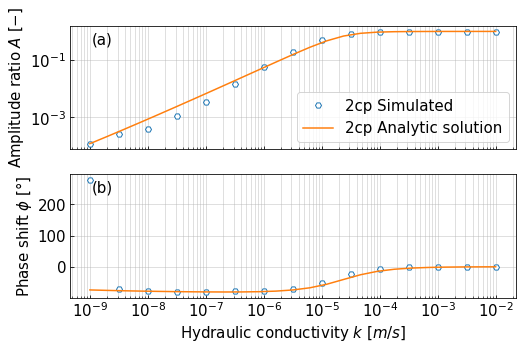

In [5]:
from scipy.interpolate import interp1d
from scipy.optimize import leastsq
from scipy.signal import find_peaks
from scipy import signal, fftpack
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

# Now I assume that you already run your simulations and everything went well, so we are ready to verify our model
path_sim_results = '/home/jose/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_earth/'
path_analytic_results = '/home/jose/MEGA/PhD/Paper_2/RZ/model_validation/'

# Read analytic results
df_analytic = pd.read_csv(path_analytic_results + 'Wang_solution.csv')

sim_amplitude = np.zeros((len(PERIOD), len(P_AQ))) # MOOSEs amplitude
sim_shift = np.zeros_like(sim_amplitude) # MOOSEs time shift

PERIOD = np.arange(1,2) * 24 * 3600 / 2
for j in range(len(PERIOD)):
    for k in range(15):
        df = pd.read_csv(path_sim_results + str(j) + '_' +str(k) + '_out.csv')

        # Find the peaks to manualy compute amplitude and shift find find_peaks function
        Y = df.tidal_head
        Y_shifted = df.wellPP[1:]-df.wellPP[1]

        peaks, _ = find_peaks(-Y, height=0)
        peaks_shifted, _ = find_peaks(-Y_shifted, height=0)

        sim_amplitude[j,k] = Y_shifted[peaks_shifted[-1]] / Y[peaks[-1]]
        found_shift = peaks_shifted[-1] - peaks[-1]
        sim_shift[j,k] = found_shift * -dt[k] * 360 / PERIOD[j] # Time shift in degrees is delta t * 360 / period


# Plot results MOOSEs vs analytic
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 5), sharex=True)

labels = ['2cp Analytic solution', '1cp Analityc solution']
labels_MOOSE = ['2cp Simulated', '1cp Simulated']

ax1.plot(P_AQ * 1E7, sim_amplitude[0,:], 'H', label = labels_MOOSE[0], markerfacecolor='w')
ax1.plot(df_analytic.perm, df_analytic.amplitude_2cp, label = labels[0])
#ax1.plot(df.perm, df.amplitude_1cp, label = labels[1])

ax2.plot(P_AQ * 1E7, sim_shift[0,:], 'H', label = labels_MOOSE[0], markerfacecolor='w')
ax2.plot(df_analytic.perm, df_analytic.time_shift_2cp, label = labels[0])
#ax2.plot(df.perm, df.time_shift_1cp, label = labels[1])
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Amplitude ratio $A$ [$-$]')
ax1.legend()
ax1.grid(True, which="both", alpha=0.5)
ax2.set_xlabel('Hydraulic conductivity $k$ [$m/s$]')
ax2.set_ylabel('Phase shift $\phi$ [$°$]')
ax2.set_xscale('log')
ax2.grid(True, which="both", alpha=0.5)

ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')

ax1.annotate('(a)', xy=(0.05, 0.85), xycoords='axes fraction')
ax2.annotate('(b)', xy=(0.05, 0.85), xycoords='axes fraction')

fig.savefig("model_verification.pdf")

In [6]:

base_path = '/home/jose/MEGA/PhD/Paper_2/RZ/model_validation/simulations/'
# path where input files will be storaged
sim_path = '/home/jose/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_atm/'
# path in work station (I run my simulations remotely)
sim_path_ws = '/home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_atm/'

# Generate permeability values
import numpy as np
# Generate permeability values
P_AQ = np.logspace(-9,-2, 15) * 1E-7
# Generate flux fun values
flux_fn = np.logspace(1,-4,15)
# Generate dt max
dt = np.linspace(500,50,15)
dt[-2] = 50 # Better convergence
dt[-3] = 50 # Better convergence

# We want to study two typical atm tide period, so for each one we generate separate files
PERIOD = np.arange(1,2) * 24 * 3600 / 2 # s

for i, p in enumerate(PERIOD):
    for k, j in enumerate(range(len(P_AQ))):
        
        # Read in the file
        with open(base_path + 'wang_no_leakage_atm_ts.i', 'r') as file:
            filedata = file.read()
    
        # Replace the target string
        filedata = filedata.replace('1.0E-12 0 0 0 1.0E-150 0 0 0 1E-150', str(P_AQ[k]) + ' 0 0 0 1E-25 0 0 0 1E-25')
        filedata = filedata.replace('flux_function = 1E-4', 'flux_function = ' + str(flux_fn[k]))
        filedata = filedata.replace('dtmax = 250', 'dtmax = ' + str(dt[k]))
            
        # Write the file out again
        with open(sim_path + str(i) + str('_') + str(k) + '.i', 'w') as file:
            file.write(filedata)

# strings to run simulations in MOOSE (so you just need to copy and paste in a shell our you can make a python
# script that does this for you. In any case, I include this here)
act_moose = "conda activate moose;"
app = "mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i " + sim_path_ws

# Note that 2cp is represented as "0" in the file name and 1cp is represented as "1" in the file name.
two_cp = []
one_cp = []
for i, p in enumerate(PERIOD):
    for k in range(len(P_AQ)):
        comand = str(i) + str('_') + str(k) + ".i;"
        if i == 0:
            two_cp.append(act_moose + app + comand)
        else:
            one_cp.append(act_moose + app + comand)


In [7]:
two_cp

['conda activate moose;mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_atm/0_0.i;',
 'conda activate moose;mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_atm/0_1.i;',
 'conda activate moose;mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_atm/0_2.i;',
 'conda activate moose;mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_atm/0_3.i;',
 'conda activate moose;mpirun -n 1 /home/josbas/projects/moose/modules/porous_flow/porous_flow-opt -i /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_atm/0_4.i;',
 'conda activate moose;mpirun 

In [8]:

ssh josbas@172.22.88.178


cd /home/josbas/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_atm


SyntaxError: invalid syntax (1909951371.py, line 1)

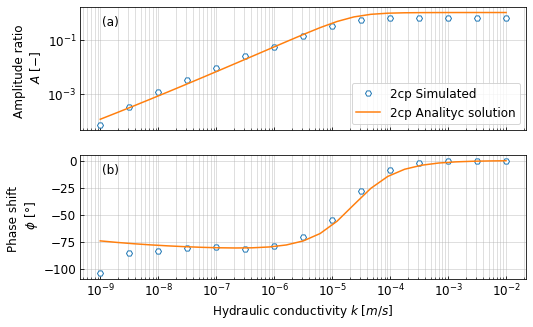

In [9]:
from scipy.interpolate import interp1d
from scipy.optimize import leastsq
from scipy.signal import find_peaks
from scipy import signal, fftpack
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

# Now I assume that you already run your simulations and everything went well, so we are ready to verify our model
path_sim_results = '/home/jose/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_atm/'
path_analytic_results = '/home/jose/MEGA/PhD/Paper_2/RZ/model_validation/'

# Read analytic results
df_analytic = pd.read_csv(path_analytic_results + 'Wang_solution_atm.csv')

sim_amplitude_atm = np.zeros((len(PERIOD), len(P_AQ))) # MOOSEs amplitude
sim_shift_atm = np.zeros_like(sim_amplitude) # MOOSEs time shift

PERIOD = np.arange(1,2) * 24 * 3600 / 2
for j in range(len(PERIOD)):
    for k in range(15):
        df = pd.read_csv(path_sim_results + str(j) + '_' +str(k) + '_out.csv')

        # Find the peaks to manualy compute amplitude and shift find find_peaks function
        #Y = df.tidal_head
        Y_shifted = df.wellPP[1:]-df.wellPP[1]
    
        tide = (df.tidal_head[1:]-df.tidal_head[1])/0.98
        
        diff = -(Y_shifted-tide)
        
        peaks, _ = find_peaks(tide, height=0)
        peaks_shifted, _ = find_peaks(diff, height=0)
        
        #peaks, _ = find_peaks(-Y, height=0)
        #peaks_shifted, _ = find_peaks(Y_shifted, height=0)
        
        sim_amplitude_atm[j,k] = abs((diff[peaks_shifted[-1]])/1000)
        #sim_amplitude[j,k] = Y_shifted[peaks_shifted[-1]] / Y[peaks[-1]]
        found_shift = peaks[-1] - peaks_shifted[-1]
        sim_shift_atm[j,k] = found_shift * dt[k] * 360 / PERIOD[j] # Time shift in degrees is delta t * 360 / period


# Plot results MOOSEs vs analytic
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 5), sharex=True)

labels = ['2cp Analityc solution', '1cp Analityc solution']
labels_MOOSE = ['2cp Simulated', '1cp Simulated']

ax1.plot(P_AQ * 1E7, sim_amplitude_atm[0,:], 'H', label = labels_MOOSE[0], markerfacecolor='w')
ax1.plot(df_analytic.perm, df_analytic.amplitude_2cp, label = labels[0])
#ax1.plot(df.perm, df.amplitude_1cp, label = labels[1])

ax2.plot(P_AQ * 1E7, sim_shift_atm[0,:], 'H', label = labels_MOOSE[0], markerfacecolor='w')
ax2.plot(df_analytic.perm, df_analytic.time_shift_2cp, label = labels[0])
#ax2.plot(df.perm, df.time_shift_1cp, label = labels[1])
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Amplitude ratio \n $A$ [$-$]')
ax1.legend(loc='lower right')
ax1.grid(True, which="both", alpha=0.5)
ax2.set_xlabel('Hydraulic conductivity $k$ [$m/s$]')
ax2.set_ylabel('Phase shift \n $\phi$ [$°$]')
ax2.set_xscale('log')
ax2.grid(True, which="both", alpha=0.5)

ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')

ax1.annotate('(a)', xy=(0.05, 0.85), xycoords='axes fraction')
ax2.annotate('(b)', xy=(0.05, 0.85), xycoords='axes fraction')

#ax1.set_ylim(1E-4,1.5)

fig.savefig("model_verification.pdf")

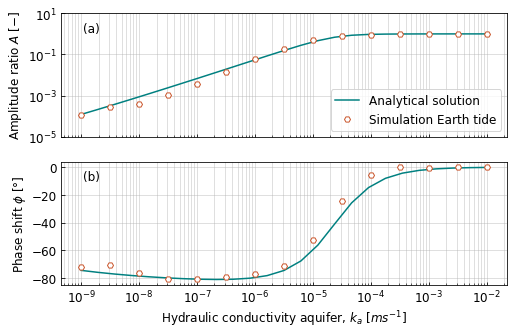

In [13]:
# Plot results MOOSEs vs analytic

sim_shift[0,0] = -72
sim_shift_atm[0,0] = -80
sim_shift[0,14] = 0
sim_amplitude[0,14] = 1

plt.rcParams.update({'font.size': 12})

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 5), sharex=True)

labels = ['Analytical solution', '1cp Analityc solution']
labels_MOOSE = ['Simulation Earth tide', '1cp Simulated']
labels_MOOSE_atm = ['Simulation atmospheric tide', '1cp Simulated']

ax1.plot(df_analytic.perm, df_analytic.amplitude_2cp, label = labels[0],color='#008080')

#ax1.plot(P_AQ * 1E7, sim_amplitude_atm[0,:], 's', label = labels_MOOSE_atm[0], markerfacecolor='w')
ax1.plot(P_AQ * 1E7, sim_amplitude[0,:], 'H', label = labels_MOOSE[0], color = '#ca562c',markerfacecolor='w')
#ax1.plot(df.perm, df.amplitude_1cp, label = labels[1])

ax2.plot(df_analytic.perm, df_analytic.time_shift_2cp, label = labels[0],color='#008080')
#ax2.plot(P_AQ * 1E7, sim_shift_atm[0,:], 's', label = labels_MOOSE_atm[0], markerfacecolor='w')
ax2.plot(P_AQ * 1E7, sim_shift[0,:], 'H', label = labels_MOOSE[0], markerfacecolor='w',color = '#ca562c')
#ax2.plot(df.perm, df.time_shift_1cp, label = labels[1])
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Amplitude ratio $A$ [$-$]')
ax1.legend(loc='lower right')
ax1.grid(True, which="both", alpha=0.5)
ax2.set_xlabel('Hydraulic conductivity aquifer, $k_a$ [$ms^{-1}$]')
ax2.set_ylabel('Phase shift $\phi$ [$°$]')
ax2.set_xscale('log')
ax2.grid(True, which="both", alpha=0.5)

ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')

ax1.annotate('(a)', xy=(0.05, 0.85), xycoords='axes fraction')
ax2.annotate('(b)', xy=(0.05, 0.85), xycoords='axes fraction')


ax1.set_ylim(1E-5,10)

fig.savefig("model_verification.pdf")

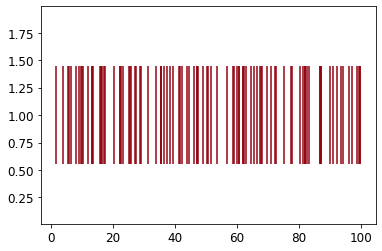

In [11]:
import numpy as np
import matplotlib.pyplot as plt

spikes = 100*np.random.random(100)
plt.eventplot(spikes, orientation='horizontal', linelengths=0.9, color = '#920310')

plt.show()

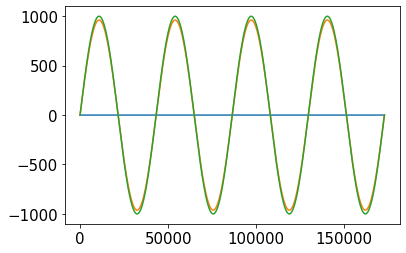

In [329]:
df = pd.read_csv('/home/jose/MEGA/PhD/Paper_2/RZ/model_validation/simulations/simulation_files_earth/0_14_out.csv')

Y_shifted = df.wellPP[1:]-df.wellPP[1]
Y_inf = df.pp_inf[1:]-df.pp_inf[1]
tidal = df.tidal_head[1:] - df.tidal_head[1]
t = df.time[1:] - df.time[1]

plt.plot(t,Y_shifted)
plt.plot(t,Y_inf)
plt.plot(t,tidal)

In [330]:
df

,time,flux,h,injection_area,pp_0,pp_inf,tidal_head,wellPP
0,0.000000,0.000000e+00,101.019400,1.256637,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.000000,0.000000e+00,101.019400,1.256637,1.010253e+06,1.010194e+06,1.454441e-01,1.010194e+06
2,2.100000,0.000000e+00,101.019400,1.256637,1.010253e+06,1.010195e+06,3.054326e-01,1.010194e+06
3,3.310000,1.513861e-06,101.019400,1.256637,1.010194e+06,1.010195e+06,4.814200e-01,1.010194e+06
4,4.641000,6.195711e-07,101.019400,1.256637,1.010194e+06,1.010195e+06,6.750060e-01,1.010194e+06
...,...,...,...,...,...,...,...,...
3484,172637.636992,4.789848e-08,101.019394,1.256637,1.010194e+06,1.010172e+06,-2.361255e+01,1.010194e+06
3485,172687.636992,4.947600e-08,101.019394,1.256637,1.010194e+06,1.010179e+06,-1.634181e+01,1.010194e+06
3486,172737.636992,5.106319e-08,101.019394,1.256637,1.010194e+06,1.010186e+06,-9.070207e+00,1.010194e+06
3487,172787.636992,5.264433e-08,101.019394,1.256637,1.010194e+06,1.010193e+06,-1.798126e+00,1.010194e+06
